In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   145M      0  0:00:05  0:00:05 --:--:--  156M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


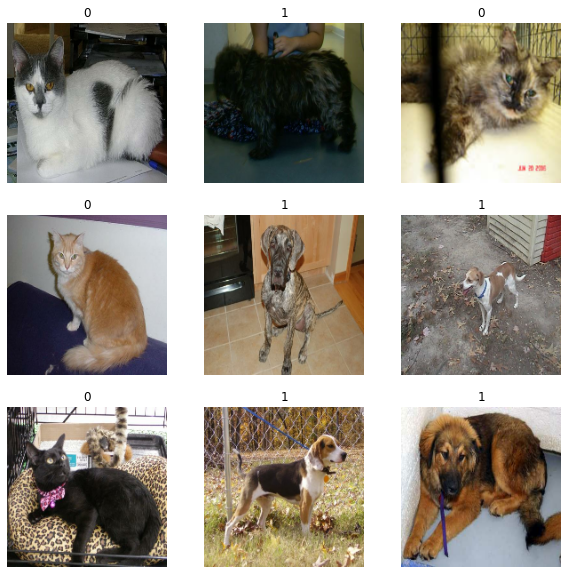

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.25),
    ]
)

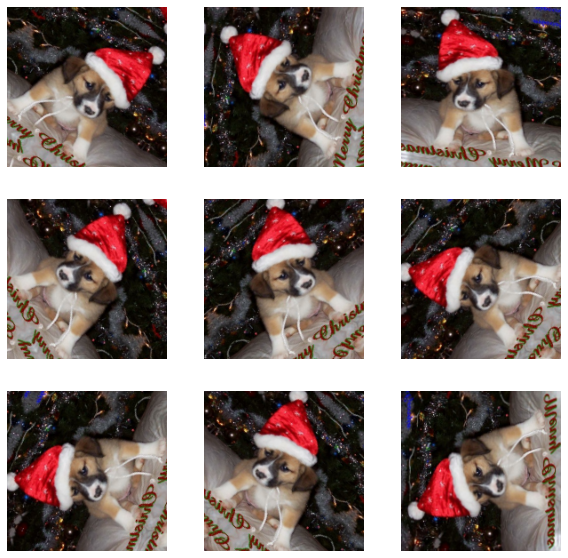

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [18]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [19]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

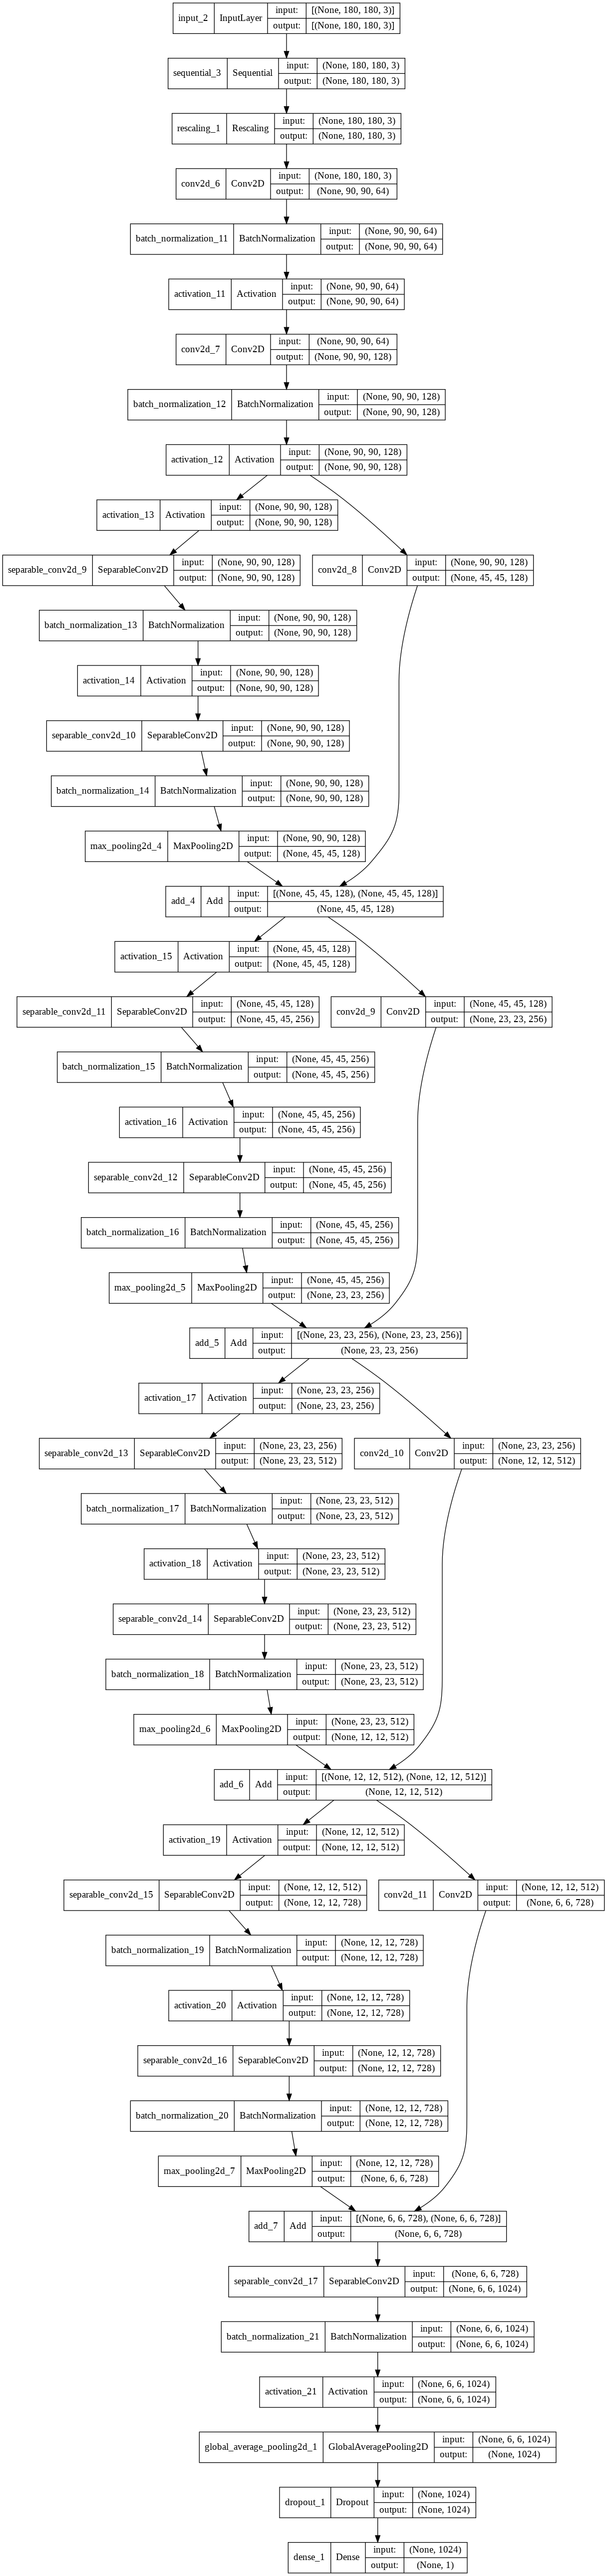

In [21]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x) # It was 32 before, now 64
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(128, 3, padding="same")(x) # It was 64 before, now 128
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [23]:
epochs = 10 # It was 50, now 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
586/586 [==============================] - ETA: 0s - loss: 0.6408 - accuracy: 0.6548

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


586/586 [==============================] - 368s 622ms/step - loss: 0.6408 - accuracy: 0.6548 - val_loss: 0.6353 - val_accuracy: 0.6529
Epoch 2/10
586/586 [==============================] - 362s 617ms/step - loss: 0.5501 - accuracy: 0.7237 - val_loss: 1.1434 - val_accuracy: 0.5906
Epoch 3/10
586/586 [==============================] - 361s 616ms/step - loss: 0.4908 - accuracy: 0.7652 - val_loss: 0.5968 - val_accuracy: 0.6978
Epoch 4/10
586/586 [==============================] - 362s 617ms/step - loss: 0.4335 - accuracy: 0.8049 - val_loss: 0.5027 - val_accuracy: 0.7663
Epoch 5/10
586/586 [==============================] - 363s 618ms/step - loss: 0.3935 - accuracy: 0.8242 - val_loss: 0.3177 - val_accuracy: 0.8723
Epoch 6/10
586/586 [==============================] - 361s 616ms/step - loss: 0.3386 - accuracy: 0.8548 - val_loss: 0.2992 - val_accuracy: 0.8763
Epoch 7/10
586/586 [==============================] - 362s 617ms/step - loss: 0.2975 - accuracy: 0.8708 - val_loss: 0.3220 - val_accura

In [49]:
for i in range(5,10): # Sample 5 cats input

  img = keras.preprocessing.image.load_img(
      "PetImages/Cat/677"+str(i)+".jpg", target_size=image_size
  )

  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]
  print(
      "This image is %.2f percent cat and %.2f percent dog."
      % (100 * (1 - score), 100 * score)
  )

print("---------------------------------------------------------")

for j in range(5,10): # Sample 5 dogs input
  img2 = keras.preprocessing.image.load_img(
      "PetImages/Dog/1000"+str(j)+".jpg", target_size=image_size
  )

  img_array2 = keras.preprocessing.image.img_to_array(img2)
  img_array2 = tf.expand_dims(img_array2, 0)  # Create batch axis

  predictions = model.predict(img_array2)
  score = predictions[0]
    
  print(
      "This image is %.2f percent cat and %.2f percent dog."
      % (100 * (1 - score), 100 * score)
  )

This image is 81.51 percent cat and 18.49 percent dog.
This image is 98.21 percent cat and 1.79 percent dog.
This image is 95.98 percent cat and 4.02 percent dog.
This image is 85.49 percent cat and 14.51 percent dog.
This image is 99.42 percent cat and 0.58 percent dog.
---------------------------------------------------------
This image is 12.99 percent cat and 87.01 percent dog.
This image is 1.30 percent cat and 98.70 percent dog.
This image is 6.12 percent cat and 93.88 percent dog.
This image is 17.32 percent cat and 82.68 percent dog.
This image is 10.63 percent cat and 89.37 percent dog.


In [ ]:
# Data augmentation has been done by 0.25 rotate ratio by horizontally.
# Conv2D layer values are change from 32 to 64 and 64 to 128.
# Epochs amount is lowered. It was 50 and I set it as 10 because validation loss wasn't dropping after maximum 10 epochs.

# Model results seem fine. I have made two loops for five cats and five dogs image testing. All predictions are consistent.
# Original values were %84.34 cat and %15.66 dog for the cat image 6779 but in my trained model, it is %99.42 cat and %0.58 dog.